# Developer Survey Analysis

The goal is this analysis is to analyze the 2018 Stack Overflow survey results and gain relevant insights pertaining to developers, in particular the subgroup that identifies themselves as data scientist. We are interested in studying whether they differ from developers. Some questions we are interested in right off the bat are:
- what are the most popular languages among developers? Among data scientists?
- what are the determinants of job satisfaction? Do data scientists seem more/less satisfied with their jobs, after controlling for confounding variables?
- is it possible to extract different data scientist "archetypes" from this survey? Do they differ from developers as a broader group?

We will leverage descriptive statistics as well as modeling to answer all these questions. We will analyze the results collected by Stack Overflow and made publicly available [here](https://insights.stackoverflow.com/survey).

In [1]:
# We start by loading the necessary libraries
import pandas as pd
import numpy as np
from sklearn import linear_model
import matplotlib.pyplot as plt
import statsmodels.api as sm
from scipy import stats
import zipfile
from sklearn.cluster import KMeans
import os
import re
import math
from collections import defaultdict
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso, Ridge
from sklearn.metrics import r2_score, mean_squared_error, make_scorer
from sklearn.grid_search import GridSearchCV

%matplotlib inline

/anaconda3/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools
/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/grid_search.py:42: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


## Loading the Data

In [2]:
# We first extract the file from its archive and then ingest it into Pandas

zip_ref = zipfile.ZipFile('developer_survey_2018.zip', 'r')
zip_ref.extractall(os.getcwd())
zip_ref.close()

data_2018 = pd.read_csv('survey_results_public.csv')
schema_2018 = pd.read_csv('survey_results_schema.csv')

/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2728: DtypeWarning: Columns (8,12,13,14,15,16,50,51,52,53,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83,84,85,93,94,95,96,97,98,99,100,101,102,103,104,105,106,107,108,109,110,111,112,113,114,115,116,117,118,119,120,121,122,123,124,125,126,127,128) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Initial Assessment

In [3]:
print('The 2018 survey had {} respondents and {} variables'.format(str(data_2018.shape[0]),
                            str(data_2018.shape[1])))

The 2018 survey had 98855 respondents and 129 variables


In [4]:
# The schema will serve as a useful guide
schema_2018.head()

,Column,QuestionText
0,Respondent,Randomized respondent ID number (not in order ...
1,Hobby,Do you code as a hobby?
2,OpenSource,Do you contribute to open source projects?
3,Country,In which country do you currently reside?
4,Student,"Are you currently enrolled in a formal, degree..."


In [5]:
# We can print out the data type of each column
data_2018.dtypes

Respondent                       int64
Hobby                           object
OpenSource                      object
Country                         object
Student                         object
Employment                      object
FormalEducation                 object
UndergradMajor                  object
CompanySize                     object
DevType                         object
YearsCoding                     object
YearsCodingProf                 object
JobSatisfaction                 object
CareerSatisfaction              object
HopeFiveYears                   object
JobSearchStatus                 object
LastNewJob                      object
AssessJob1                     float64
AssessJob2                     float64
AssessJob3                     float64
AssessJob4                     float64
AssessJob5                     float64
AssessJob6                     float64
AssessJob7                     float64
AssessJob8                     float64
AssessJob9               

The 2018 survey gathered responses from almost 100,000 people, on 129 questions. We have both numeric and categorical variables, which we will need to encode in order to be able to plug them in machine learning models.

## Data Preparation

### Missing Values

We assess the presence of missing values, and deal with them.

In [6]:
# We assess the proportion of missing values in each column
data_2018.isnull().mean().sort_values(ascending = False)

TimeAfterBootcamp              0.932710
MilitaryUS                     0.840362
HackathonReasons               0.740114
ErgonomicDevices               0.655475
AdBlockerReasons               0.618178
StackOverflowJobsRecommend     0.612392
JobEmailPriorities1            0.532517
JobEmailPriorities2            0.532517
JobEmailPriorities3            0.532517
JobEmailPriorities4            0.532517
JobEmailPriorities6            0.532517
JobEmailPriorities5            0.532517
JobEmailPriorities7            0.532517
ConvertedSalary                0.517455
JobContactPriorities3          0.507299
JobContactPriorities4          0.507299
JobContactPriorities2          0.507299
JobContactPriorities1          0.507299
JobContactPriorities5          0.507299
Salary                         0.488362
SalaryType                     0.483385
FrameworkWorkedWith            0.477821
TimeFullyProductive            0.475272
AdBlockerDisable               0.444661
FrameworkDesireNextYear        0.441424


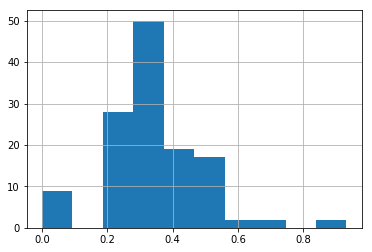

In [7]:
data_2018.isnull().mean(axis = 0).hist();

In [8]:
# We drop the columns with more than 60% of missing values
data_2018 = data_2018.loc[:, data_2018.isnull().mean() < 0.6]

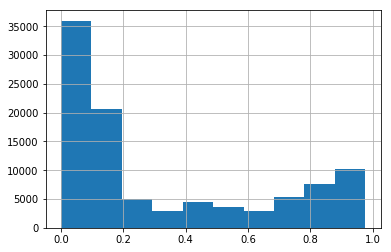

In [9]:
# We now assess the rows
data_2018.isnull().mean(axis = 1).hist();

In [10]:
# We drop the rows with more than 80% of missing values
data_2018 = data_2018.loc[data_2018.isnull().mean(axis = 1) < 0.8,:]

In [11]:
print('After removing missing values, we are left with {} respondents and {} variables'.format(str(data_2018.shape[0]),
                            str(data_2018.shape[1])))

After removing missing values, we are left with 82184 respondents and 123 variables


We assess missing values in rows and columns. We remove columns which have more than 50% of missing values, as well as rows that have more than 80% of missing values, for both these groups do not provide us with useful information for our purposes. We are still left with 123 variables and 82,184 respondents. We will probably have to impute or do more cleaning later on, but this is a good first pass for now.

### Duplicate Values

In [12]:
print(data_2018.Respondent.duplicated().sum(), data_2018.duplicated().sum())

0 0


No duplicate values to deal with. 

### Categorical Variables

In [13]:
# We transform the salary variable from a categorical to a numerical variables
data_2018.Salary = pd.to_numeric(data_2018.Salary.str.replace(',', ''), errors = 'coerce')

In [14]:
# Create a numerical representation of JobSatisfaction for predictions later
mapping = {'Extremely dissatisfied': 0, 'Moderately dissatisfied': 1, 'Slightly dissatisfied': 2, 
           'Neither satisfied nor dissatisfied':3, 'Sligthly satisfied':4, 'Moderately satisfied': 5, 
           'Extremely satisfied': 6, np.nan: 7}
satisf_labels = list(mapping.keys())
data_2018.JobSatisfaction = data_2018.JobSatisfaction.map(mapping)

In [15]:
# We create a new column that specifies whether someone is a data scientist

pattern = ['Data or business analyst' , 'Data scientist or machine learning specialist']
data_2018.dropna(subset = ['DevType'], axis = 0, inplace = True)
data_scientists = data_2018['DevType'].str.contains('|'.join(pattern))
data_2018['DataScientist'] = 0
data_2018.DataScientist.loc[data_scientists] = 1

/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


Later in our analysis, we will want to use the salary variable, which we thus convert to numeric (it was viewed as categorical due to the thousand separator certain respondents used). We also create a numerical representation of job satisfaction, to be used in multi-class classification later on. Finally, we encode whether someone is a data scientist as a binary variable, and drop the job variable, since we are interested in comparing data scientists to other developers as a whole.

We will use one-hot encoding for our categorical variables later on.

## Languages

We want to look at languages they've worked with, as well as what they want to learn in the future to see whether there is agreement as well as whether it is possible to discern a trend.

In [16]:
# We start by only keeping non-null elements of the dataframe
data_2018_languages_past = data_2018.loc[data_2018.LanguageWorkedWith.notnull(),:]

In [17]:
# We extract all the possible languages through a helper function

def extract_unique_values(df, column):
    '''
    INPUT:
    df - a dataframe
    column - a column of a dataframe with values separated with a semicolon

    OUTPUT:
    unique_values - a list of unique values present in the column
    '''
    df[column].dropna(inplace = True)
    unique_values = []

    for i in df[column].unique():
        for j in i.split(';'):
            if not j in unique_values:
                unique_values.append(j)
    return(unique_values)

languages = extract_unique_values(data_2018_languages_past, 'LanguageWorkedWith')

/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:2993: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)


In [18]:
# Now that we have all the possible values, we use them to create counts for each
# We start by creating two helper functions

def total_count(df, col1, col2, look_for):
    '''
    INPUT:
    df - the pandas dataframe you want to search
    col1 - the column name you want to look through
    col2 - the column you want to count values from
    look_for - a list of strings you want to search for in each row of df[col]

    OUTPUT:
    new_df - a dataframe of each look_for with the count of how often it shows up
    '''
    new_df = defaultdict(int)
    #loop through list of languages
    for val in look_for:
        #loop through rows
        for idx in range(df.shape[0]):
            #if the ed type is in the row add 1
            if val in df[col1][idx]:
                new_df[val] += int(df[col2][idx])
    new_df = pd.DataFrame(pd.Series(new_df)).reset_index()
    new_df.columns = [col1, col2]
    new_df.sort_values('count', ascending=False, inplace=True)
    return new_df


def compute_unique_count(df, col, rename_index, unique_values):
    '''
    INPUT:
    df - the pandas dataframe from which to extract the values
    col - the column whose value counts we want
    rename_index - a string to rename the index of our resulting dataframe
    unique_values - a list of unique values for which we want the counts

    OUTPUT:
    counts - a dataframe of each value with its associated counts
    '''
    
    counts = df[col].value_counts().reset_index()
    counts.rename(columns={'index': rename_index, col: 'count'}, inplace=True)
    counts = total_count(counts, rename_index, 'count', unique_values)
    counts.set_index(rename_index, inplace = True)
    
    return(counts)

In [19]:
# We can now process our dataframe to extract all the counts for the values
languages_overall = compute_unique_count(data_2018_languages_past, 'LanguageWorkedWith', 'language', languages)

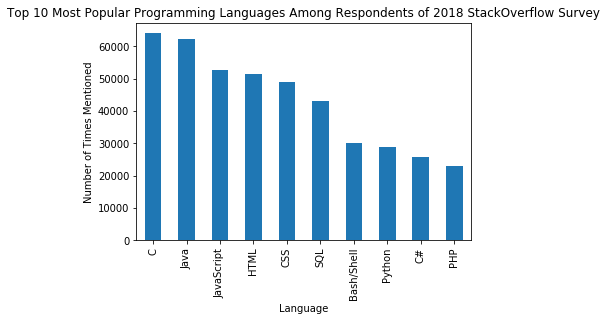

In [20]:
# We can now plot the popularity of various languages overall
# We only keep the top 10
languages_overall.head(10).plot(kind = 'bar', legend = None);
plt.title("Top 10 Most Popular Programming Languages Among Respondents of 2018 StackOverflow Survey");
plt.xlabel("Language");
plt.ylabel("Number of Times Mentioned");

In [21]:
# We create two datasets, one for data scientists/analysts and one for the rest
data_2018_languages_past_DS = data_2018_languages_past.loc[data_2018_languages_past.DataScientist == 1,:]
data_2018_languages_past_noDS = data_2018_languages_past.loc[data_2018_languages_past.DataScientist == 0,:]

In [22]:
# We now repeat the analysis
languages_DS = compute_unique_count(data_2018_languages_past_DS, 'LanguageWorkedWith', 'language', languages)
languages_noDS = compute_unique_count(data_2018_languages_past_noDS, 'LanguageWorkedWith', 'language', languages)

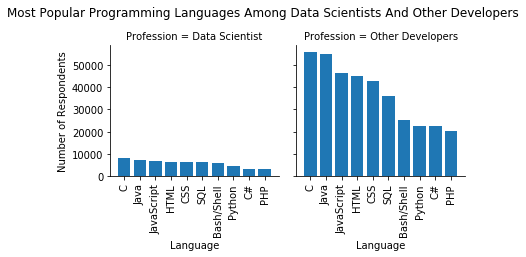

In [23]:
# We can now create a dataframe from these two and build a faceted plot

def create_faceted_plot(df_DS, df_noDS, plot_title, xlabel, ylabel):
    '''
    INPUT:
    df_DS - a Pandas dataframe of counts for Data Scientists
    df_noDS - a Pandas dataframe of counts for other developers
    plot_title - a string, title to give to our plot
    xlabel - a string, label for our x axis
    ylabel - a string, label for our y axis

    OUTPUT:
    a faceted plot
    '''
    
    df_DS['Profession'] = 'Data Scientist'
    df_noDS['Profession'] = 'Other Developers'
    df = pd.concat([df_DS.head(10), df_noDS.head(10)], axis = 0)
    df.reset_index(inplace = True)
    g = sns.FacetGrid(df, col = "Profession")
    g.map(plt.bar, 'language', 'count')
    g.set_xticklabels(rotation = 90)
    g.set_xlabels(xlabel)
    g.set_ylabels(ylabel)
    plt.subplots_adjust(top=0.8)
    g.fig.suptitle(plot_title)
    plt.show()

create_faceted_plot(languages_DS, languages_noDS,
                   "Most Popular Programming Languages Among Data Scientists And Other Developers",
                   "Language", "Number of Respondents")

/anaconda3/lib/python3.6/site-packages/pandas/core/series.py:2993: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(result)


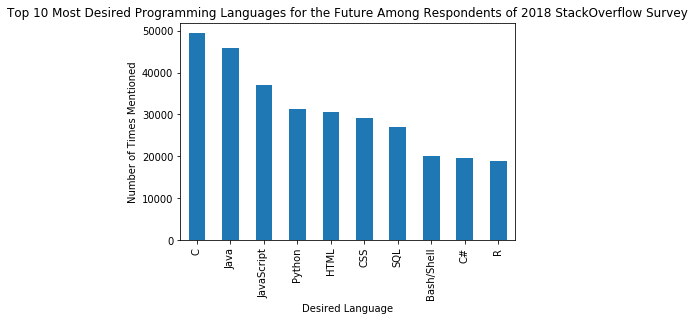

In [24]:
# We can now repeat the same analysis, for languages people want to work with in the future
# We first look at it overall

data_2018_languages_future = data_2018.loc[data_2018.LanguageDesireNextYear.notnull(),:]
languages_future = extract_unique_values(data_2018_languages_future, 'LanguageDesireNextYear')
languages_future_overall = compute_unique_count(data_2018_languages_future,
                                                'LanguageDesireNextYear', 'language', languages_future)
languages_future_overall.head(10).plot(kind = 'bar', legend = None);
plt.title("Top 10 Most Desired Programming Languages for the Future Among Respondents of 2018 StackOverflow Survey");
plt.xlabel("Desired Language");
plt.ylabel("Number of Times Mentioned");

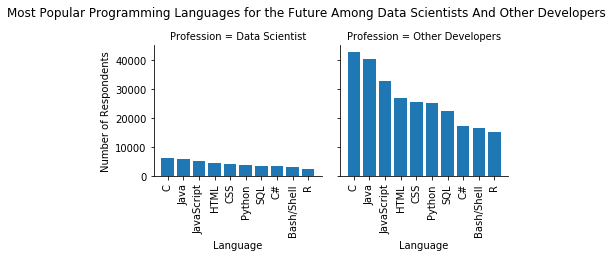

In [25]:
# We can then split it between data scientists and other developers
data_2018_languages_future_DS = data_2018_languages_future.loc[data_2018_languages_future.DataScientist == 1,:]
data_2018_languages_future_noDS = data_2018_languages_future.loc[data_2018_languages_future.DataScientist == 0,:]

languages_future_DS = compute_unique_count(data_2018_languages_future_DS, 
                                           'LanguageDesireNextYear', 'language', languages_future)
languages_future_noDS = compute_unique_count(data_2018_languages_future_noDS,
                                             'LanguageDesireNextYear', 'language', languages_future)
create_faceted_plot(languages_future_DS, languages_future_noDS,
                   "Most Popular Programming Languages for the Future Among Data Scientists And Other Developers",
                   "Language", "Number of Respondents")

### Interpretation

We get several valuable insights from this analysis.

First of all, data scientists do not differ from other developers in terms of languages they have used in the past or want to work with in the future. This is interesting as a lot of the languages mentioned are not the first ones we think about for data science (C, PHP, JavaScript). They could nonetheless point to data scientists being proficient in these efficient languages to deploy models into production, rather than simply doing ad hoc analyses in Python or R.

In addition, comparing languages used in the past with those who are an objective in the future, most of the languages are the same and in a similar order. The main differences are the rise in popularity of Python and R. These two languages have been rising in popularity in recent years with the explosion of data science, with the creation of many libraries to do state-of-the-art machine learning. It is no coincidence that the rise of these two languages happens at a time when the profession is considered attractive. Many developers, data scientists or not, want to work with them as they are the most widely used techniques.

## Determinants of job satisfaction

## Descriptive Statistics

In [26]:
# We start by creating a copy of our data frame
data_2018_satisf = data_2018.copy()

# We drop the respondent variable which is simply an identifier
data_2018_satisf.drop('Respondent', axis = 1, inplace = True)

In [27]:
# We look at the mean
data_2018_satisf.groupby('DataScientist')['JobSatisfaction'].mean()

DataScientist
0    4.700198
1    4.624523
Name: JobSatisfaction, dtype: float64

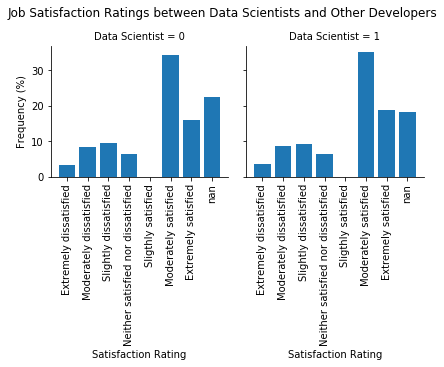

In [28]:
# We compare the distributions
satisf_df = data_2018_satisf[['DataScientist', 'JobSatisfaction']]
satisf_df_plot = satisf_df.groupby(['DataScientist', 'JobSatisfaction'])['JobSatisfaction'].count().groupby(level = 0).apply(lambda x:
                                                 100 * x / float(x.sum()))
satisf_df_plot.index.set_names(['Data Scientist', 'Satisfaction Rating'], inplace = True)
satisf_df_plot = satisf_df_plot.reset_index()
satisf_df_plot.rename(columns = {'JobSatisfaction':'Proportion'}, inplace = True)

g = sns.FacetGrid(satisf_df_plot, col = 'Data Scientist')
g.map(plt.bar, 'Satisfaction Rating', 'Proportion')
g.set_xticklabels(rotation = 90)
g.set_xlabels('Satisfaction Rating')
g.set_ylabels('Frequency (%)')
g.set(xticklabels=satisf_labels, xticks=np.arange(0,8,1))
plt.subplots_adjust(top=0.8)
g.fig.suptitle('Job Satisfaction Ratings between Data Scientists and Other Developers')
plt.show()

In [29]:
satisf_df_plot.set_index(['Data Scientist', 'Satisfaction Rating'])

Proportion
Data Scientist Satisfaction Rating            
0              0.0                    3.208565
               1.0                    8.348767
               2.0                    9.409624
               3.0                    6.496735
               5.0                   34.187868
               6.0                   16.016831
               7.0                   22.331611
1              0.0                    3.544565
               1.0                    8.665636
               2.0                    9.108707
               3.0                    6.512107
               5.0                   35.188047
               6.0                   18.773828
               7.0                   18.207110

## Modeling

In [90]:
# We first have to remove missing values from the JobSatisfaction column since it is our target variable

data_2018_satisf = data_2018_satisf.dropna(subset = ['JobSatisfaction'], axis = 0)

In [91]:
# We focus on a subset of our variables to build our model
# We choose them based on domain-knowledge and our intuition

predictors = ['Hobby', 'Exercise', 'Gender', 'DevType', 'OpenSource', 'SexualOrientation', 'EducationTypes',
            'DataScientist', 'NumberMonitors', 'UndergradMajor', 'TimeFullyProductive',
              'RaceEthnicity', 'Age', 'Employment', 'Dependents', 'CompanySize', 
              'YearsCoding', 'WakeTime', 'HoursComputer', 'YearsCodingProf', 'OperatingSystem',
             'HoursOutside', 'SkipMeals', 'FormalEducation', 'HopeFiveYears',
              'ConvertedSalary', 'JobSatisfaction']

data_2018_satisf_subset = data_2018_satisf.loc[:,predictors]

In [92]:
# We need to encode ourselves the DevType, EducationTypes, Gender, SexualOrientation and DevType columns
for c in ['EducationTypes', 'DevType', 'RaceEthnicity', 'Gender', 'SexualOrientation']:
    data_2018_satisf_subset = pd.concat([data_2018_satisf_subset, data_2018_satisf_subset[c].str.get_dummies(sep = ';')], 
                                        axis = 1)
    data_2018_satisf_subset.drop(c, inplace = True, axis = 1)


/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:194: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [93]:
# We impute missing values for the salary columns

data_2018_satisf_subset['ConvertedSalary'] = data_2018_satisf_subset['ConvertedSalary'].fillna(data_2018_satisf_subset['ConvertedSalary'].median())

# We create our dummy variables
data_2018_satisf_dummies = pd.get_dummies(data_2018_satisf_subset)

In [94]:
# We separate our predictor from our target variable
X = data_2018_satisf_dummies.drop(labels = 'JobSatisfaction', axis = 1)
y = data_2018_satisf_dummies['JobSatisfaction']

# We can now build our models
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

# Linear Regression
lm = LinearRegression(normalize = True)
lm.fit(X_train, y_train)
lm_y_test_preds = lm.predict(X_test)
lm_y_train_preds = lm.predict(X_train)

lm_r2_train = lm.score(X_train, y_train)
lm_r2_test = lm.score(X_test, y_test)

lm_rmse_train = math.sqrt(mean_squared_error(y_train, lm_y_train_preds))
lm_rmse_test = math.sqrt(mean_squared_error(y_test, lm_y_test_preds))

print("The R2 score on the train set is {} and {} on the test set with linear regression".format(lm_r2_train, lm_r2_test))
print("The RMSE is {} on the train set and {} on the test set with linear regression". format(lm_rmse_train, lm_rmse_test))

# Lasso
lasso = Lasso(normalize = True)
lasso.fit(X_train, y_train)
lasso_y_test_preds = lasso.predict(X_test)
lasso_y_train_preds = lasso.predict(X_train)

lasso_r2_train = lasso.score(X_train, y_train)
lasso_r2_test = lasso.score(X_test, y_test)

lasso_rmse_train = math.sqrt(mean_squared_error(y_train, lasso_y_train_preds))
lasso_rmse_test = math.sqrt(mean_squared_error(y_test, lasso_y_test_preds))

print("The R2 score on the train set is {} and {} on the test set with Lasso regression".format(lasso_r2_train, 
                                                                                                lasso_r2_test))
print("The RMSE is {} on the train set and {} on the test set with Lasso regression". format(lasso_rmse_train,
                                                                                             lasso_rmse_test))

# Ridge
ridge = Ridge(normalize = True)
ridge.fit(X_train, y_train)
ridge_y_test_preds = ridge.predict(X_test)
ridge_y_train_preds = ridge.predict(X_train)

ridge_r2_train = ridge.score(X_train, y_train)
ridge_r2_test = ridge.score(X_test, y_test)

ridge_rmse_train = math.sqrt(mean_squared_error(y_train, ridge_y_train_preds))
ridge_rmse_test = math.sqrt(mean_squared_error(y_test, ridge_y_test_preds))

print("The R2 score on the train set is {} and {} on the test set with Ridge regression".format(ridge_r2_train, 
                                                                                                ridge_r2_test))
print("The RMSE is {} on the train set and {} on the test set with Ridge regression". format(ridge_rmse_train,
                                                                                             ridge_rmse_test))

The R2 score on the train set is 0.3459097150809418 and 0.3457395342358274 on the test set with linear regression
The RMSE is 1.656358017527729 on the train set and 1.6600599405091117 on the test set with linear regression
The R2 score on the train set is 0.0 and -4.127736797587822e-05 on the test set with Lasso regression
The RMSE is 2.048025524255059 on the train set and 2.052378201961116 on the test set with Lasso regression
The R2 score on the train set is 0.2558244725028759 and 0.2556504553532939 on the test set with Ridge regression
The RMSE is 1.7667416884611347 on the train set and 1.770667001865983 on the test set with Ridge regression


In [95]:
# Ridge Regression seems to be the most promising one, as well as the one most likely to generalize
# We use GridSearch to find the optimal value of alpha parameter and whether normalizing helps
# We fit on our entire dataset

ridge = Ridge()

parameters = {'alpha': [0.1,0.25,0.75,1,1.5,2], 'normalize': [True, False]}

scorer = make_scorer(r2_score)

grid_obj = GridSearchCV(ridge, parameters, scorer)

grid_fit = grid_obj.fit(X, y)

best_ridge = grid_fit.best_estimator_

preds = best_ridge.predict(X)

r_2 = best_ridge.score(X,y)

rmse = math.sqrt(mean_squared_error(y, preds))

print('The r-squared is {} and the RMSE is {}'.format(r_2, rmse))

/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.344092606021645e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 9.505969284795399e-17 / 1.1102230246251565e-16
  RuntimeWarning)
/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 7.430251503482789e-17 / 1.1102230246251565e-16
  RuntimeWarning)


The r-squared is 0.3327402683901002 and the RMSE is 1.673659801123723


In [96]:
coef_df = pd.DataFrame({'Features':X.columns, 'Coefficient': best_ridge.coef_})
coef_df[['Features', 'Coefficient']].sort_values('Coefficient', axis = 0)

,Features,Coefficient
170,HopeFiveYears_Working in a career completely u...,-1.377315
91,"Employment_Independent contractor, freelancer,...",-1.001844
171,HopeFiveYears_Working in a different or more s...,-0.976830
167,HopeFiveYears_Working as a founder or co-found...,-0.887023
77,TimeFullyProductive_More than a year,-0.752731
166,HopeFiveYears_Retirement,-0.728727
168,HopeFiveYears_Working as a product manager or ...,-0.727376
169,HopeFiveYears_Working as an engineering manage...,-0.671384
142,YearsCodingProf_9-11 years,-0.664033
78,TimeFullyProductive_Nine months to a year,-0.643733


### Interpretation

Good news: developers in general are happy with their job, with an average rating between sligthly and moderately satisfied. There is no significant difference for the subgroup of data scientists, with a slight tendency to have a higher satisfaction and to rate as being extremely satisfied. 

We can build a model to see which elements correlate most closely with a high or low satisfaction at work. Our model only explains 35% of the variability in the job satisfaction, but we find that C-suite executives, those with a lot of monitors, with PhD's, younger, product managers who constantly acquire new skills are the happiest while contractors or part-time employees later in their careers, as well as people in very large companies, tend to have lower job satisfaction. The sweet spot: mid sized company, where they have opportunities for growth and learning and are well-treated (number of monitors).

## Archetypes

Subset only a few variables of interest (salary, education, languages used, big/small company, job satisfaction, experience) Drill in within the data scientist profession in the US, and repeat the analysis for developers, comparing the two. Use the dummy variable for DS here, and do the clustering on the two subsets.

We will only create 3 clusters, because we do not want to get at an optimal solution but rather extract some underlying structure of the data.

In [99]:
# We start by creating a copy of our data frame
data_2018_cluster = data_2018.copy()

# We drop the respondent variable which is simply an identifier
data_2018_cluster.drop('Respondent', axis = 1, inplace = True)

In [117]:
# We focus on a subset of our variables to build our model
# We choose them based on domain-knowledge and our intuition

predictors = ['Hobby', 'Country', 'Exercise', 'Gender', 'OpenSource', 'EducationTypes',
              'SexualOrientation', 'DataScientist', 'NumberMonitors', 'UndergradMajor', 'TimeFullyProductive',
              'RaceEthnicity', 'Age', 'Employment', 'Dependents', 'CompanySize', 
              'YearsCoding', 'WakeTime', 'HoursComputer', 'YearsCodingProf', 'OperatingSystem',
             'HoursOutside', 'SkipMeals', 'FormalEducation', 'HopeFiveYears',
              'ConvertedSalary', 'JobSatisfaction', 'DevType']


data_2018_cluster_subset = data_2018_cluster.loc[:,predictors]

for c in ['EducationTypes', 'DevType', 'RaceEthnicity', 'Gender', 'SexualOrientation']:
    data_2018_cluster_subset = pd.concat([data_2018_cluster_subset, data_2018_cluster_subset[c].str.get_dummies(sep = ';')], 
                                        axis = 1)
    data_2018_cluster_subset.drop(c, inplace = True, axis = 1)
    
# We impute missing values for the salary and job satisfaction columns

for c in ['ConvertedSalary', 'JobSatisfaction']:
    data_2018_cluster_subset[c] = data_2018_cluster_subset[c].fillna(data_2018_cluster_subset[c].median())

# We create our dummy variables
data_2018_cluster_dummies = pd.get_dummies(data_2018_cluster_subset)

# We standardize our data
scaler = StandardScaler()
cluster_data_scaled = scaler.fit_transform(data_2018_cluster_dummies)
cluster_data_scaled = pd.DataFrame(cluster_data_scaled, columns = data_2018_cluster_dummies.columns)

In [118]:
def cluster(df, k):
    '''
    INPUTS:
    df - data we want to cluster
    k - number of clusters desired

    OUTPUT:
    a dataframe of features as observations and clusters as columns, values being the center value
    '''
    
    model = KMeans(n_clusters=k)
    model.fit(df)
    first_cluster_center = model.cluster_centers_[0]
    second_cluster_center = model.cluster_centers_[1]
    third_cluster_center = model.cluster_centers_[2]
    
    centers_df = pd.DataFrame({'Feature': df.columns.values,
                               'First Cluster Center': first_cluster_center,
                               'Second Cluster Center': second_cluster_center,
                               'Third Cluster Center': third_cluster_center})
    
    return centers_df

In [119]:
# We extract three clusters for the whole dataset
overall_centers = cluster(cluster_data_scaled, 3)

In [120]:
def extract_top_features(center_df, k, top = 5):
    '''
    INPUTS:
    center_df - a dataframe with centers for various clusters
    k - which cluster we want to focus on
    top - how many features to visualize

    OUTPUT:
    prints out the most important features for this cluster
    '''
    
    chosen_cluster = center_df.set_index('Feature').iloc[:,k]
    ordered_centers = chosen_cluster.sort_values()
    
    print('The top {} negative features are: \n {} \n \nWhile the top {} positive features are \n {}'.format(
    top, ordered_centers[:top], top, ordered_centers[-(top+1):-1]))

In [121]:
# Looking at the first cluster
extract_top_features(overall_centers,0)

The top 5 negative features are: 
 Feature
Male                                                                                -0.889609
Straight or heterosexual                                                            -0.885924
Taught yourself a new language, framework, or tool without taking a formal course   -0.797687
White or of European descent                                                        -0.721928
Age_25 - 34 years old                                                               -0.663079
Name: First Cluster Center, dtype: float64 
 
While the top 5 positive features are 
 Feature
YearsCodingProf_0-2 years                            0.327624
Employment_Not employed, and not looking for work    0.401300
Employment_Not employed, but looking for work        0.425957
YearsCoding_0-2 years                                0.450211
JobSatisfaction                                      0.475851
Name: First Cluster Center, dtype: float64


In [122]:
# The second cluster
extract_top_features(overall_centers,1)

The top 5 negative features are: 
 Feature
Age_35 - 44 years old                           -0.309495
JobSatisfaction                                 -0.243846
Student                                         -0.204327
YearsCoding_30 or more years                    -0.204036
Employment_Not employed, but looking for work   -0.198644
Name: Second Cluster Center, dtype: float64 
 
While the top 5 positive features are 
 Feature
YearsCodingProf_3-5 years                                                            0.319492
Taught yourself a new language, framework, or tool without taking a formal course    0.336186
Male                                                                                 0.399503
Straight or heterosexual                                                             0.403873
Dependents_No                                                                        0.475734
Name: Second Cluster Center, dtype: float64


In [123]:
# And the third cluster
extract_top_features(overall_centers,2)

The top 5 negative features are: 
 Feature
Age_25 - 34 years old       -0.627635
YearsCodingProf_0-2 years   -0.555606
YearsCoding_3-5 years       -0.525448
YearsCodingProf_3-5 years   -0.493091
Age_18 - 24 years old       -0.474286
Name: Third Cluster Center, dtype: float64 
 
While the top 5 positive features are 
 Feature
YearsCodingProf_15-17 years     0.683350
YearsCodingProf_18-20 years     0.701733
YearsCoding_30 or more years    0.755281
Age_45 - 54 years old           0.793500
Dependents_Yes                  0.981562
Name: Third Cluster Center, dtype: float64


In [124]:
# Repeating the analysis for data scientists
# We subset before scaling, and drop the data scientist column afterwards
data_scientist = data_2018_cluster_dummies.DataScientist == 1
cluster_data_DS = data_2018_cluster_dummies.loc[data_scientist,:]
cluster_data_DS.drop('DataScientist', axis = 1, inplace = True)

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [125]:
# We scale and apply our function
DS_scaler = StandardScaler()
DS_scaled = DS_scaler.fit_transform(cluster_data_DS)
DS_scaled = pd.DataFrame(DS_scaled, columns = cluster_data_DS.columns)

DS_centers = cluster(DS_scaled, 3)

In [126]:
# For the first cluster
extract_top_features(DS_centers,0)

The top 5 negative features are: 
 Feature
Straight or heterosexual                                                            -0.620287
Male                                                                                -0.520286
White or of European descent                                                        -0.409342
OperatingSystem_Windows                                                             -0.336752
Taught yourself a new language, framework, or tool without taking a formal course   -0.317759
Name: First Cluster Center, dtype: float64 
 
While the top 5 positive features are 
 Feature
Asexual                                              1.317964
East Asian                                           1.527238
Non-binary, genderqueer, or gender non-conforming    1.598664
HoursComputer_Less than 1 hour                       2.523431
Transgender                                          4.082594
Name: First Cluster Center, dtype: float64


In [127]:
# For the second cluster
extract_top_features(DS_centers,1)

The top 5 negative features are: 
 Feature
Student                                         -0.301083
YearsCodingProf_0-2 years                       -0.276552
Employment_Not employed, but looking for work   -0.216105
Age_18 - 24 years old                           -0.203312
Country_India                                   -0.195405
Name: Second Cluster Center, dtype: float64 
 
While the top 5 positive features are 
 Feature
Age_25 - 34 years old                                                                0.290019
Employment_Employed full-time                                                        0.304007
Taught yourself a new language, framework, or tool without taking a formal course    0.376618
Male                                                                                 0.400906
Straight or heterosexual                                                             0.412004
Name: Second Cluster Center, dtype: float64


In [128]:
# The third cluster
extract_top_features(DS_centers,2)

The top 5 negative features are: 
 Feature
White or of European descent                                                        -0.720369
Straight or heterosexual                                                            -0.685446
Male                                                                                -0.671120
Taught yourself a new language, framework, or tool without taking a formal course   -0.638956
Employment_Employed full-time                                                       -0.518793
Name: Third Cluster Center, dtype: float64 
 
While the top 5 positive features are 
 Feature
JobSatisfaction                                  0.322461
Age_18 - 24 years old                            0.352705
Country_India                                    0.353670
Employment_Not employed, but looking for work    0.363748
YearsCodingProf_0-2 years                        0.471703
Name: Third Cluster Center, dtype: float64


In [129]:
# Finally for non-data scientists
cluster_data_noDS = data_2018_cluster_dummies.loc[data_scientist==False,:]
cluster_data_noDS.drop('DataScientist', axis = 1, inplace = True)

/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()


In [130]:
noDS_scaler = StandardScaler()
noDS_scaled = noDS_scaler.fit_transform(cluster_data_noDS)
noDS_scaled = pd.DataFrame(noDS_scaled, columns = cluster_data_noDS.columns)

noDS_centers = cluster(noDS_scaled, 3)

In [131]:
# Looking at the first cluster
extract_top_features(noDS_centers,0)

The top 5 negative features are: 
 Feature
Male                                                                                -0.869708
Straight or heterosexual                                                            -0.866559
Taught yourself a new language, framework, or tool without taking a formal course   -0.778955
White or of European descent                                                        -0.699595
Age_25 - 34 years old                                                               -0.667679
Name: First Cluster Center, dtype: float64 
 
While the top 5 positive features are 
 Feature
FormalEducation_Secondary school (e.g. American high school, German Realschule or Gymnasium, etc.)    0.322445
Employment_Not employed, and not looking for work                                                     0.404804
Employment_Not employed, but looking for work                                                         0.418065
YearsCoding_0-2 years                                       

In [132]:
# Second cluster
extract_top_features(noDS_centers,1)

The top 5 negative features are: 
 Feature
Age_25 - 34 years old       -0.629785
YearsCodingProf_0-2 years   -0.555595
YearsCoding_3-5 years       -0.534959
YearsCodingProf_3-5 years   -0.501781
Age_18 - 24 years old       -0.483682
Name: Second Cluster Center, dtype: float64 
 
While the top 5 positive features are 
 Feature
YearsCodingProf_15-17 years     0.711280
YearsCodingProf_18-20 years     0.727128
YearsCoding_30 or more years    0.762686
Age_45 - 54 years old           0.807670
Dependents_Yes                  0.998504
Name: Second Cluster Center, dtype: float64


In [133]:
# Third cluster
extract_top_features(noDS_centers,2)

The top 5 negative features are: 
 Feature
Age_35 - 44 years old                           -0.307799
JobSatisfaction                                 -0.254066
Student                                         -0.226754
Employment_Not employed, but looking for work   -0.199710
YearsCoding_30 or more years                    -0.194288
Name: Third Cluster Center, dtype: float64 
 
While the top 5 positive features are 
 Feature
YearsCodingProf_3-5 years                                                            0.321614
Taught yourself a new language, framework, or tool without taking a formal course    0.337713
Male                                                                                 0.399683
Straight or heterosexual                                                             0.403462
Dependents_No                                                                        0.465789
Name: Third Cluster Center, dtype: float64


### Interpretation

Among respondents of the survey, we have three main archetypes of respondents:
- unemployed young developers who have started to code only recently
- mid-career male coder who tries to learn new skills on his own time
- older developers with children

Drilling deeper, among data scientists:
- asian ethnicity who studied computer science in school who are non-binary and non-heterosexual
- straight white male, mid-career, learning new languages on his own time, potentially did not study it in school
- indians who studied computer science in school, have just started a career they are very satisfied with